# Homework 09 - RNNs

In this homework you will learn how to generate text with an RNN. 

Defining an RNN in TensorFlow is based on a specific framework. Therefore I will provide you with the correct model definition. Your task will be to to understand how the model processes sequential data, which kind of data it returns and how to train it.

You will train a stacked RNN to generate text passages, similar to those in the bible.
For that make sure that the 'bible.txt' (from Stud.IP) file is in the same folder as this notebook.

In [1]:
import numpy as np
import tensorflow as tf
import random
import math

### Load text.

In [2]:
# Load the text.
txt = open("bible.txt",'r').read()
print("Text length: {}".format(len(txt)))
print('-------------------------------------')

# Inspect first lines:
print(txt[:500])

Text length: 4332496
-------------------------------------
The First Book of Moses:  Called Genesis


1:1 In the beginning God created the heaven and the earth.

1:2 And the earth was without form, and void; and darkness was upon
the face of the deep. And the Spirit of God moved upon the face of the
waters.

1:3 And God said, Let there be light: and there was light.

1:4 And God saw the light, that it was good: and God divided the light
from the darkness.

1:5 And God called the light Day, and the darkness he called Night.
And the evening and the mornin


In [3]:
# Get the vocabulary of the text
vocab = list(set(txt))
print("Vocabulary: {}".format(vocab))
print('--------------------------')
vocab_size = len(vocab)
print("Vocabulary size: {}".format(vocab_size))

Vocabulary: ['!', 'L', 'f', '2', '6', 'p', 'F', 'M', 'Y', 'U', 'J', 'z', 'B', 'g', ';', 'e', 'S', 'O', '1', 'v', 'h', 'k', 'N', 'C', ' ', 'T', 'n', '9', 'W', 's', '7', 'i', 'E', 'y', '3', ':', '0', 'o', 'a', 'd', 'A', 'j', '-', 'Q', '4', 'H', 't', '8', 'q', 'w', 'P', 'r', '\n', 'b', '.', ')', 'x', 'Z', '(', '*', 'c', 'l', 'K', 'R', 'D', "'", 'V', 'I', 'u', ',', '?', 'G', 'm', '5']
--------------------------
Vocabulary size: 74


In [4]:
# Create dictionaries to switch between the indices of the characters and the characters themselves.
char2idx = {ch:i for i,ch in enumerate(vocab)}
idx2char = {i:ch for i,ch in enumerate(vocab)}

# Translate the text to indices.
txt_idx = [char2idx[ch] for ch in txt]

### Prepare TensorFlow dataset.

In the following we will process the text to a suitable dataset.

In [5]:
# First create a tensorflow dataset out of the text (in indices). (tf.data.Dataset.from_tensor_slices)
### YOUR CODE HERE ###
dataset = tf.data.Dataset.from_tensor_slices(txt_idx)
######################

In [6]:
# We will trainon subsequences of length 20 and compute the loss for each timestep.
# Let's think about how a single training datapoint will look.
# Example:
# Input sequence: "Moses:  Called Genesi"
# Target sequence: "oses:  Called Genesis"
# To create these pairs of sequence we chunk the dataset into subsequences of length k+1.
# You can use .batch() for this. 
# And make sure that all subsequences in the resulting dataset have length k+1 (understand
# parameter 'drop_remainder' in .batch())

### YOUR CODE HERE ###
k = 20
dataset = dataset.batch(k+1, drop_remainder=True)
######################

In [7]:
# Now we have to map each sequence of length 21
# to a (input, target) pair.
# Given the following function you can use the dataset method .map() here.
def input_target_split(seq):
    return seq[:-1], seq[1:]

### YOUR CODE HERE ###
dataset = dataset.map(lambda x: (input_target_split(x)))
######################

In [8]:
# Now as usual we shuffle our dataset and chunk it into batches of 64.
### YOUR CODE HERE ###
BATCH_SIZE = 64
dataset = dataset.shuffle(len(txt) // (k+1))
dataset = dataset.batch(BATCH_SIZE)
######################

In [9]:
# Provided definitions of Vanilla RNN cell and RNN model.

class VanillaRNNCell(tf.keras.layers.Layer):

    def __init__(self, input_dim, units):
        super(VanillaRNNCell, self).__init__()
        self.input_dim = input_dim
        self.units = units
        # TF needs this.
        self.state_size = units
    
    def build(self, input_shape):
        self.w_in = self.add_weight(
                            shape=(self.input_dim, self.units),
                            initializer='uniform'
                            )
        self.w_h = self.add_weight(
                            shape=(self.units, self.units),
                            initializer='uniform'
                            )
        self.b_h = self.add_weight(
                            shape=(self.units,),
                            initializer='zeros'
                            )       
            
    def call(self, inputs, hidden_states):
        h_prev = hidden_states[0]
        h_new = tf.nn.sigmoid(tf.matmul(inputs, self.w_in) + tf.matmul(h_prev, self.w_h) + self.b_h)
        return h_new, [h_new]

state_size_1 = 128
state_size_2 = 256

class RNN(tf.keras.layers.Layer):
    
    def __init__(self):
        super(RNN, self).__init__()
        self.cell_1 = VanillaRNNCell(input_dim=vocab_size, units=state_size_1)
        self.cell_2 = VanillaRNNCell(input_dim=state_size_1, units=state_size_2)
        self.cells = [self.cell_1, self.cell_2]
        self.rnn = tf.keras.layers.RNN(self.cells, return_sequences=True)
        self.output_layer = tf.keras.layers.Dense(units=vocab_size, activation=tf.nn.softmax)
        
    def call(self,x):
        seqs = self.rnn(x)
        output = self.output_layer(seqs)
        return output

In [10]:
tf.keras.backend.clear_session()

### YOUR CODE HERE ### 
# Initialize the RNN, cross entropy as a loss function and as an optimizer Adam with learning rate 0.01.
model = RNN()
cross_entropy = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Train for one epoch. Your loss should be around 1.4.
# Remember to encode the inputs and target values as one hots.
losses = []
train_steps = []

num_batches = math.ceil((len(txt) // (k+1)) / BATCH_SIZE)
step = 0
for batch in zip(dataset):
    (x, t) = batch[0]
    x = tf.one_hot(indices=x, depth=vocab_size)
    t = tf.one_hot(indices=t, depth=vocab_size)
    with tf.GradientTape() as tape:
        output = model(x)
        loss = cross_entropy(t, output)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    losses.append(loss)
    train_steps.append(step)
    
    if step % 100 == 0:
        print('')
        print('loss: ' + str(loss.numpy()))
        print(str(step) + ' / ' + str(num_batches))
        
    step = step + 1

######################    


loss: 4.5473375
0 / 3223

loss: 2.5339332
100 / 3223

loss: 2.1979616
200 / 3223

loss: 1.9921982
300 / 3223

loss: 1.932592
400 / 3223

loss: 1.7703936
500 / 3223

loss: 1.7694575
600 / 3223

loss: 1.7325157
700 / 3223

loss: 1.7255255
800 / 3223

loss: 1.7241148
900 / 3223

loss: 1.6128525
1000 / 3223

loss: 1.5952408
1100 / 3223

loss: 1.513009
1200 / 3223

loss: 1.6029091
1300 / 3223

loss: 1.4548628
1400 / 3223

loss: 1.5219576
1500 / 3223

loss: 1.5586116
1600 / 3223

loss: 1.4175893
1700 / 3223

loss: 1.5458534
1800 / 3223

loss: 1.512428
1900 / 3223

loss: 1.468601
2000 / 3223

loss: 1.4901549
2100 / 3223

loss: 1.5473168
2200 / 3223

loss: 1.4642771
2300 / 3223

loss: 1.4004709
2400 / 3223

loss: 1.4274213
2500 / 3223

loss: 1.439476
2600 / 3223

loss: 1.4429433
2700 / 3223

loss: 1.4141674
2800 / 3223

loss: 1.4886546
2900 / 3223

loss: 1.4440966
3000 / 3223

loss: 1.4475137
3100 / 3223

loss: 1.3604487
3200 / 3223


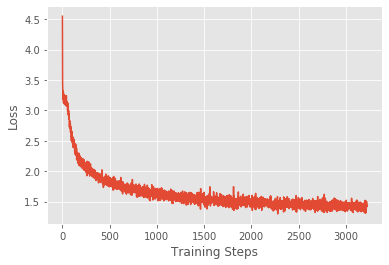

In [14]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure()
plt.plot(train_steps, losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

In [15]:
# IT MIGHT MAKE SENSE TO FIRST CODE THE ACTUAL TRAINING CELL (NEXT ONE) AND THEN COME BACK HERE.

# Defining the function for generating novel text samples.
# The function should take the sample below (of length k) and generate a text sequence of length k+n from it.
def generate_sample(sample, n):
    
    ### YOUR CODE HERE ###
    # Translate sample string into list of characters.
    chars = [[char2idx[char] for char in sample]]

    # Transform list into tensor of shape (1,20,vocab_size)
    chars = tf.one_hot(indices=chars, depth=vocab_size)
    
    ######################
    
    # Sample n new characters.
    for i in range(n):
        ### YOUR CODE HERE ###
        # Feed sample sequence into RNN and get probabilities of next character.
        probabilities = model(chars)
        
        # Sample index for new character (use tf.random.categorical()).
        probabilities = tf.math.log(probabilities[0])
        probabilities = tf.random.categorical(probabilities, 1)
        idx = probabilities.numpy()[19][0]

        # Translate to actual character and add it to sample string.
        char = idx2char[idx]

        # Create new sequence of 20 indices by deleting the first character of the old sequence
        # and adding the new character.
        sample = sample + char
        
        chars = [[char2idx[char] for char in sample[i + 1:]]]
        chars = tf.one_hot(indices=chars, depth=vocab_size)

        ######################
        
    return sample

In [16]:
# Feel free to generate some funny samples.

sample = 'And God and Jesus go'
assert(len(sample)==k)
print(generate_sample(sample,1000))

And God and Jesus goned him ford of the field in him
gravelb pharre congrest.

6:8 The God was of Jern go me the
Israel: and he to
destrest: of the sickness: teer with all the land, by the family
of his men knowning afroses; lenger of men they wenth him, Every priest, of the people ble.

:6 Tell sacrifice: but ye holy likese him, and voice he reight; Spirit of his brethrel it gold of host break the other Jarmorres; and they will was to brought of a queturns which is this restst rabbaar according
the people come against the people are pure put ligpeth it.

13:16 Thou shalt blesself still flediah be not the city many years made according of Israel with the chastines of his helsazie day God, and requices
of my sons'sed.

10:6 And everiedwen, and will sill Israel sacriface to his fatten were man's preyert the son of Amazar.

6:12 And the destroy came boted them that defore the kink.

24:53 Beedonady uncought men Hathan, tonly
offering
him unto Me out; neither is the king's wilder evilse, I

In [48]:
sample = 'Jesus just played ou'
assert(len(sample)==k)
print(generate_sample(sample,1000))

Jesus just played out of thy name down for the moved with fakent and Solomon not by man sot to him; and our hundrow, and upon the sword.

11:17 Who said
unto theme are
a tation in all
find for I will be take ence; for it for the
lands up against the , and Horbs, and that thou hast made for if the consuries
that were an hust sinneth things laid up, shelt that the swent
afteth be might that if my ramsiah or not be togethen against by even a unto him: neither whrn take the viritan
for she hath have not onement on the kingty
the God op
with the father in the LORD pidereth that be out shall parts or thine hand in
the asself, he that
laid, To come know one with their woman will
also throm David saw and up for
the Lord, and
no fathery, when Bethan sea under together
carcumcus of
thy house were made doeth with up for that Afpasnes, in take the graving of heavant went I will
make pass, as their ason will give
the
king of the king, I knownem
also also to pass, which I will ye will
two debath kno

In [49]:
sample = 'God just did the big'
assert(len(sample)==k)
print(generate_sample(sample,1000))

God just did the bight himself liber him not hand
of the srue himselves.

15:45 And David he arment be witer upon was neither
oppribsay into her madement in the sonst my son of his midst of
your caster upon thy
God over.


7:10 It am your witnen, and saying unto Moses; t.

25:15
With
rams of Porden.
 13:14 Therefore I will none depart
with
plessed ye ask one tome his epige to your years of my sake he have will
done drink our honour face out of our moth have take ot my
fearuneth upounto the lamb, Behold, and whelt
is he thy
son of Baty upon glad; he have deat brother, sware of Israel, and a not thou fath into him
rusbly Fathert first also is comb? if thou wust, I am takened, in ye had
scittle be be not in hunselion, and one forth
him and Syria was one his house of Marnadaa, we pray a sought daid in Phily in ifruction.

17:18 And Jalamy breaming to talaom he to
which diss that let thee, even with Zionlest out of the pittren, and Pheria, it work of agaat said unto Judah, that we habsen th

In [51]:
sample = 'After God and his br'
assert(len(sample)==k)
print(generate_sample(sample,150))

After God and his breasts of Jodamies hath for his saith
the mercy oveth of like
whose king my give, if if ye smote you, Whomin that he hath two said unto passed like riv


In [17]:
sample = 'After the rap battle'
assert(len(sample)==k)
print(generate_sample(sample,90))

After the rap battle, but yet be strong of Christ, and; 20:16 The house, lest the Phill tiken he spourt which 


In [18]:
sample = '22:19 The sea began '
assert(len(sample)==k)
print(generate_sample(sample,90))

22:19 The sea began of
the son and he delivered in the people, unfil it; O kept of thy throne, there.

139:28 


In [20]:
sample = 'Toss a coin to your '
assert(len(sample)==k)
print(generate_sample(sample,250))

Toss a coin to your work of the Song me.

11:2 We assipponing the city; but all the house of Ahazianity days, and in thee,
ye drink, and horse sake is war again and made to pass ansorrightel of ball great unto thy
Gebeednes of loo earon, This hand, he the dist.

16:66 A
